In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
sys.path.append(os.path.expanduser(os.path.join('~','Documents', 'projects', 'coronavirus')))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.graph_objects as go
import src.tools as tools
from src.models import calibrate_SEIIIRD, SEIIIRDModel, plot_SEIIIRD
import plotly.express as px
from scipy.integrate import odeint
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import scipy.integrate as integrate
from src.data_downloader import DATA_REPOS, download_from_repo

### update data from repos

In [2]:
dest='/home/maurizio/Documents/projects/coronavirus/data'

In [3]:
download_from_repo(DATA_REPOS['world']['url'], filenames=DATA_REPOS['world']['streams'], dest=dest)

last commit  2020-04-01 02:08:36


In [4]:
download_from_repo(DATA_REPOS['italy']['url'], filenames=DATA_REPOS['italy']['streams'], dest=dest)

could not retrieve repo infos,  Error -5 while decompressing data: incomplete or truncated stream


## SIRD Model definition

In [41]:
# SIR model differential equations
def SIR_deriv(y, t, N, beta, gamma, theta):
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    dDdt = theta * I
    return dSdt, dIdt, dRdt, dDdt

def SIRModel_solver(t, beta, gamma, theta):
    return SIRModel(t, beta, gamma, theta)[3] # returns just D for optimizer

def SIRModel(t, beta, gamma, theta):
    # Initial conditions vector
    y0 = S0, I0, R0, D0
    # Integrate the SIR equations over time t
    ret = odeint(SIR_deriv, y0, t, args=(N, beta, gamma, theta))
    S, I, R, D = ret.T
    return S, I, R, D

def diff_ev_solver(params):
    beta, gamma, theta = params
    return np.mean(np.abs(SIRModel_solver(x_fit, beta, gamma, theta) - y_fit))

### toy example

beta:  0.2
gamma:  0.1
theta:  0.015
r0:  2.0
mean period of time of infection:  10.0


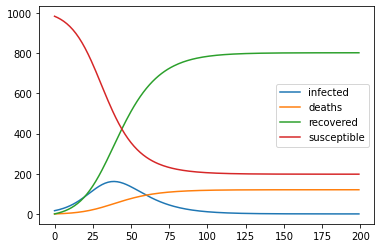

In [42]:
N = 1000 # total population Italy
I0 = 16 # Initial number of infected people (10x official estimates hypothesis)
R0 = 0 # Initial number of recovered
S0 = N - I0 - R0 # Initial susceptible population to infection.
D0 = 0 # number of deaths at initial time

params = (0.2, 0.1, 0.015)
S, I , R, D = SIRModel(range(200), *params)
print('beta: ', params[0])
print('gamma: ', params[1])
print('theta: ', params[2])
print('r0: ', params[0]/params[1])
print('mean period of time of infection: ', 1/params[1])

plt.plot(I, label='infected')
plt.plot(D, label='deaths')
plt.plot(R, label='recovered')
plt.plot(S, label='susceptible')
#plt.yscale('log')
#ax.yaxis.set_major_formatter(ScalarFormatter())

#plt.ylim(0,10000)
plt.legend()

### fit to official death data

calibrating with genetic algorithm...
beta:  -2.1934205106297107
gamma:  -2.3857984215432992
theta:  0.0032868839472196282
r0:  0.9206337413345083
mean period of time of infection:  -0.41914689479638895
max number of infections  228313.70791078097
max number of deaths  15061.060729179759
mae  56.972442606217115


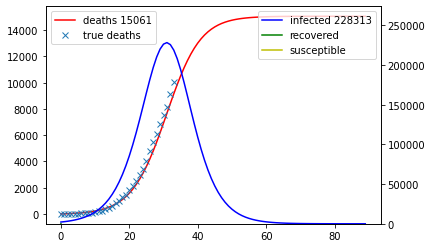

In [44]:
use_differential_evolution = True
cases_multiplier = 10
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
y_fit = df['deceduti'].values#df['deceduti'].values
x_fit = np.linspace(0, len(y_fit), len(y_fit))
N = 60431283 # total population Italy
I0 = cases_multiplier*df['totale_attualmente_positivi'].iloc[0] # Initial number of infected people (10x official estimates hypothesis)
R0 = 0 #df['dimessi_guariti'].iloc[0] # Initial number of recovered
S0 = N - I0 - R0 # Initial susceptible population to infection.
D0 = 0 # number of deaths at initial time

bounds = [(-5,5), (-5, 5), (-5, 5)]
if use_differential_evolution:
    print('calibrating with genetic algorithm...')
    optimization = differential_evolution(diff_ev_solver, bounds)
    params = optimization.x
else:
    params, covariances = curve_fit(f=SIRModel_solver, xdata=x_fit, ydata=y_fit, method='trf', bounds=bounds[0])
S, I , R, D = SIRModel(range(90), *params)
print('beta: ', params[0])
print('gamma: ', params[1])
print('theta: ', params[2])
print('r0: ', params[0]/(params[1]+params[2]))
print('mean period of time of infection: ', 1/params[1])
print('max number of infections ', np.max(I))
print('max number of deaths ', np.max(D))
print('mae ', np.mean(np.abs(y_fit - SIRModel_solver(x_fit, *params))))
fig, ax1 = plt.subplots()
ax1.plot(D,'r', label='deaths '+str(int(np.max(D))))
ax1.plot(y_fit,'x', label='true deaths')
ax1.legend(loc='upper left')
ax2 = ax1.twinx()
plt.ylim(0,1.2*np.max(I))
ax2.plot(I,'b', label='infected '+str(int(np.max(I))))
ax2.plot(R,'g', label='recovered')
ax2.plot(S,'y', label='susceptible')


ax2.legend()

## SEIR Model definition

In [48]:
def SEIRModel(t, S0, E0, I0, R0, r0, dur_inf, dur_inc):
    # SEIR model differential equations
    def SEIR_deriv(y, t, r0, dur_inf, dur_inc):
        S, E, I, R = y
        alpha = 1/dur_inc
        gamma = 1/dur_inf
        beta = r0 * gamma
        dSdt = -beta * S * I/N
        dEdt = beta * S * I/N - alpha * E
        dIdt = alpha * E - gamma * I
        dRdt = gamma * I
        return dSdt, dEdt, dIdt, dRdt
    # Initial conditions vector
    y0 = S0, E0, I0, R0
    # Integrate the SIR equations over time t
    ret = odeint(SEIR_deriv, y0, t, args=(r0, dur_inf, dur_inc))
    S, E, I, R = ret.T
    return S, E, I, R

def calibrate_SEIR(y_fit,
                   N,
                   I0,
                   R0 = 0,
                   E0 = 0,
                   CFR = 0.02,
                   time_horizon = 365,
                   bounds= [(0,5), (1, 30), (1, 30)],
                   use_differential_evolution = True):
    
    # SEIR model differential equations
    def SEIR_deriv(y, t, r0, dur_inf, dur_inc):
        S, E, I, R = y
        alpha = 1/dur_inc
        gamma = 1/dur_inf
        beta = r0 * gamma
        dSdt = -beta * S * I/N
        dEdt = beta * S * I/N - alpha * E
        dIdt = alpha * E - gamma * I
        dRdt = gamma * I
        return dSdt, dEdt, dIdt, dRdt

    def SEIRModel_solver(t, r0, dur_inf, dur_inc):
        # Initial conditions vector
        y0 = S0, E0, I0, R0
        # Integrate the SIR equations over time t
        ret = odeint(SEIR_deriv, y0, t, args=(r0, dur_inf, dur_inc))
        S, E, I, R = ret.T
        return I

    def diff_ev_solver(params):
        r0, dur_inf, dur_inc = params
        return np.mean(np.abs(SEIRModel_solver(x_fit, r0, dur_inf, dur_inc) - y_fit))    
    
    x_fit = np.linspace(0, len(y_fit), len(y_fit))
    S0 = N - I0 - R0 - E0 # Initial susceptible population to infection.
    if use_differential_evolution:
        print('calibrating with genetic algorithm...')
        optimization = differential_evolution(diff_ev_solver, bounds, popsize=150, maxiter=10000)
        params = optimization.x
    else:
        lo_bound = []
        up_bound = []
        for bound in bounds:
            lo_bound.append(bound[0])
            up_bound.append(bound[1])
        params, _ = curve_fit(f=SEIRModel_solver, xdata=x_fit, ydata=y_fit,
                                method='trf', bounds=(lo_bound, up_bound))
    r0, dur_inf, dur_inc = params
    
    total_deaths = integrate.quad(lambda x: CFR*SEIRModel((x,), S0, E0, I0, R0, r0, dur_inf, dur_inc)[2], 0, time_horizon)[0]

    print('total deaths', total_deaths)
    print('r0', params[0])
    print('infection period in days', params[1])
    print('incubation period in days', params[2])
    print('mae ',int(np.mean(np.abs(y_fit-SEIRModel_solver(x_fit, *params)))))
    return r0, dur_inf, dur_inc

def plot_SEIR(time_range, E0, I0, R0, r0, dur_inf, dur_inc, y = None):
    
    S0 = N - I0 - R0 - E0
    S, E, I, R = SEIRModel(time_range, S0, E0, I0, R0, r0, dur_inf, dur_inc)
    print('max number of infections ', int(np.max(I)))
    print('peak of infections ', np.argmax(I))
    print('max number of exposed ', int(np.max(E)))
    print('max number of recovered ', int(np.max(R)))
    
    fig, ax1 = plt.subplots()
    if y is not None:
        ax1.plot(y,'x', label='actual infected')
    ax1.plot(I,'b', label='infected - max '+str(int(np.max(I))))
    #ax1.plot(R,'g', label='recovered')
    #x1.plot(E,'y', label='exposed')
    ax1.legend(loc='upper left')

    

### check model params

max number of infections  62723
peak of infections  72
max number of exposed  115138
max number of recovered  798206


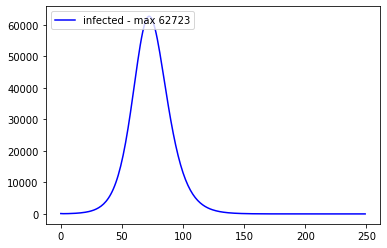

In [49]:
N = 946002
I0 = 117
R0 = 0
E0 = 0
time_range = range(250)
r0, dur_inf, dur_inc = (2.2, 2.9, 5.2)
plot_SEIR(time_range, E0, I0, R0, r0, dur_inf, dur_inc)

### calibrate to italian case

calibrating with genetic algorithm...
total deaths 16133.000000000002
r0 4.985235167638902
infection period in days 17.166740812875904
incubation period in days 1.0012200222160006
mae  73423
max number of infections  27767510
peak of infections  62
max number of exposed  2814400
max number of recovered  61396857


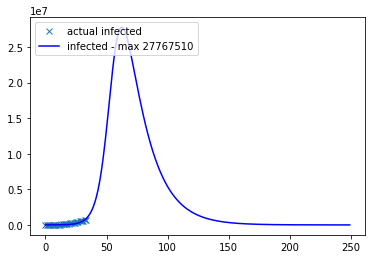

In [50]:
cases_multiplier = 10
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
N = 61836230# 60431283
I0 = cases_multiplier*df['totale_attualmente_positivi'].iloc[0]
y_fit = cases_multiplier * df['totale_attualmente_positivi'].values
R0 = 0
E0 = 0
time_range = range(250)
r0, dur_inf, dur_inc = calibrate_SEIR(y_fit = y_fit,               
                                      N = N,
                                      I0 = I0,
                                      R0 = R0,
                                      E0 = E0,
                                      CFR = 0.02,
                                      time_horizon = 365,
                                      bounds= [(0,5), (1, 30), (1, 30)],
                                      use_differential_evolution = True)
plot_SEIR(time_range, E0, I0, R0, r0, dur_inf, dur_inc, y_fit)

## SEIRD Model definition

In [88]:
def SEIRDModel(t, S0, E0, I0, R0, D0, r0, dur_inf, dur_inc, theta):
    # SEIR model differential equations
    def SEIRD_deriv(y, t, r0, dur_inf, dur_inc, theta):
        S, E, I, R, D = y
        alpha = 1/dur_inc
        gamma = 1/dur_inf
        beta = r0 * (gamma)# + theta)
        dSdt = -beta * S * I/N
        dEdt = beta * S * I/N - alpha * E
        dIdt = alpha * E - gamma * I# - theta * I
        dRdt = gamma * I * (1 - theta)
        dDdt = theta * I# * (1 - gamma)
        return dSdt, dEdt, dIdt, dRdt, dDdt
    # Initial conditions vector
    y0 = S0, E0, I0, R0, D0
    # Integrate the SIR equations over time t
    ret = odeint(SEIRD_deriv, y0, t, args=(r0, dur_inf, dur_inc, theta))
    S, E, I, R, D = ret.T
    return S, E, I, R, D

def calibrate_SEIRD(y_fit,
                   N,
                   I0,
                   R0 = 0,
                   E0 = 0,
                   D0 = 0,                   
                   time_horizon = 365,
                   bounds= [(0,5), (1, 30), (1, 30), (0,1.)],
                   use_differential_evolution = True):
    
    # SEIR model differential equations
    def SEIRD_deriv(y, t, r0, dur_inf, dur_inc, theta):
        S, E, I, R, D = y
        alpha = 1/dur_inc
        gamma = 1/dur_inf
        beta = r0 * (gamma + theta)
        dSdt = -beta * S * I/N
        dEdt = beta * S * I/N - alpha * E
        dIdt = alpha * E - gamma * I# - theta * I
        dRdt = gamma * I * (1 - theta)
        dDdt = theta * I# * (1 - gamma)
        return dSdt, dEdt, dIdt, dRdt, dDdt

    def SEIRDModel_solver(t, r0, dur_inf, dur_inc, theta):
        # Initial conditions vector
        y0 = S0, E0, I0, R0, D0
        # Integrate the SIR equations over time t
        ret = odeint(SEIRD_deriv, y0, t, args=(r0, dur_inf, dur_inc, theta))
        S, E, I, R, D = ret.T
        return D

    def diff_ev_solver(params):
        r0, dur_inf, dur_inc, theta = params
        return np.mean(np.abs(SEIRDModel_solver(x_fit, r0, dur_inf, dur_inc, theta) - y_fit))    
    
    x_fit = np.linspace(0, len(y_fit), len(y_fit))
    S0 = N - I0 - R0 - E0 - D0 # Initial susceptible population to infection.
    if use_differential_evolution:
        print('calibrating with genetic algorithm...')
        optimization = differential_evolution(diff_ev_solver, bounds, popsize=150, maxiter=10000)
        params = optimization.x
    else:
        lo_bound = []
        up_bound = []
        for bound in bounds:
            lo_bound.append(bound[0])
            up_bound.append(bound[1])
        params, _ = curve_fit(f=SEIRDModel_solver, xdata=x_fit, ydata=y_fit,
                                method='trf', bounds=(lo_bound, up_bound))
    r0, dur_inf, dur_inc, theta = params
    
    #total_deaths = integrate.quad(lambda x: CFR*SEIRModel((x,), S0, E0, I0, R0, r0, dur_inf, dur_inc)[2], 0, 250)[0]

    print('CFR ', theta)
    print('r0', params[0])
    print('infection period in days', params[1])
    print('incubation period in days', params[2])
    print('mae ',int(np.mean(np.abs(y_fit-SEIRDModel_solver(x_fit, *params)))))
    return r0, dur_inf, dur_inc, theta

def plot_SEIRD(time_range, E0, I0, R0, D0, r0, dur_inf, dur_inc, theta, y = None):
    
    S0 = N - I0 - R0 - E0 - D0
    S, E, I, R, D = SEIRDModel(time_range, S0, E0, I0, R0, D0, r0, dur_inf, dur_inc, theta)
    print('max number of infections ', int(np.max(I)))
    print('peak of infections ', np.argmax(I))
    print('max number of exposed ', int(np.max(E)))
    print('max number of recovered ', int(np.max(R)))
    print('max number of deaths ', int(np.max(D)))
    
    fig, ax1 = plt.subplots()
    if y is not None:
        ax1.plot(y,'x', label='actual deaths')
    ax1.plot(I,'b', label='infected - max '+str(int(np.max(I))))
    ax1.plot(D,'r', label='deaths - max '+str(int(np.max(D))))
    #x1.plot(E,'y', label='exposed')
    ax1.legend(loc='upper left')

    

### check model params

max number of infections  3150220
peak of infections  158
max number of exposed  5283637
max number of recovered  46647956
max number of deaths  2564453


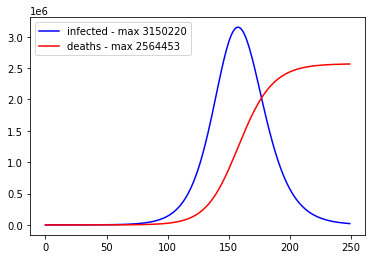

In [89]:
cases_multiplier = 10
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
N = 61836230
I0 = 120
R0 = 0
E0 = 0
D0 = 0
time_range = range(250)
r0, dur_inf, dur_inc, theta = (1.9, 3.61, 5.95, 0.015)
plot_SEIRD(time_range, E0, I0, R0, D0, r0, dur_inf, dur_inc, theta)

### calibrate to italian case

calibrating with genetic algorithm...
CFR  0.10114287871839023
r0 1.3151951524230145
infection period in days 26.246158584478835
incubation period in days 1.019067149302817
mae  231
max number of infections  3623
peak of infections  249
max number of exposed  182
max number of recovered  10230
max number of deaths  30212


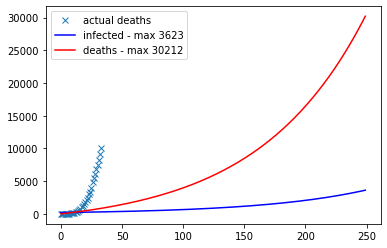

In [92]:
cases_multiplier = 1
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
N = 61836230# 60431283
I0 = cases_multiplier*df['totale_attualmente_positivi'].iloc[0]
y_fit = df['deceduti'].values
R0 = 0
E0 = 0
D0 = 0
time_range = range(250)
r0, dur_inf, dur_inc, theta = calibrate_SEIRD(y_fit = y_fit,               
                                      N = N,
                                      I0 = I0,
                                      R0 = R0,
                                      E0 = E0,
                                      D0 = D0,
                                      time_horizon = 365,
                                      bounds= [(0,5), (1, 30), (1, 30), (0,1)],
                                      use_differential_evolution = True)
plot_SEIRD(time_range, E0, I0, R0, D0, r0, dur_inf, dur_inc, theta, y_fit)

## SEIIIRD Model definition

### check model params

In [5]:
FracCritical = 0.10
DeathRateCritical = 0.55
DurICU = 15
CFR = DeathRateCritical*FracCritical
mu = (1/DurICU)*(CFR/FracCritical)
print('mu',mu)
print('CFR', CFR)

mu 0.03666666666666667
CFR 0.05500000000000001


In [6]:
from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider
import ipywidgets as widgets

In [83]:
time_range

range(1, 300)

In [89]:
beta1slider = widgets.FloatSlider(min=0.,max=1.,step=.01,description='beta1:',value=.3)
beta2slider = widgets.FloatSlider(min=0.,max=1.,step=.01,description='beta2:',value=.3)
beta3slider = widgets.FloatSlider(min=0.,max=1.,step=.01,description='beta3:',value=.3)
def sigmoid_demo(b1, b2, b3):
    print(b1*b2*b3)
beta1slider.observe(sigmoid_demo)
w = interactive(sigmoid_demo, b1=beta1slider.value, b2=5, b3=3)

display(w)

interactive(children=(FloatSlider(value=0.3, description='b1', max=0.8999999999999999, min=-0.3), IntSlider(va…

In [106]:
N = 1000
I10 = 1
I20 = 0
I30 = 0
R0 = 0
E0 = 0
D0 = 0
S0 = N-I10-I20-I30-R0-E0-D0
time_range = range(1,300)
w=interactive(plot_SEIIIRD, 
              time_range = widgets.IntRangeSlider(value=(1, 3000), min=1,max=300), 
              S0=N-I10-I20-I30-R0-E0-D0,
              E0=E0,
              I10=I10,
              I20=I20,
              I30=I30,
              R0=R0,
              D0=D0,
              beta1=widgets.FloatSlider(min=0.,max=1.,step=.01,description='beta1:',value=.3),
              beta2=widgets.FloatSlider(min=0.,max=1.,step=.01,description='beta2:',value=.01), 
              beta3=widgets.FloatSlider(min=0.,max=1.,step=.01,description='beta3:',value=.01), 
              IncubPeriod = widgets.IntSlider(value=5,min=0,max=30),
              DurMildInf = widgets.IntSlider(value=8,min=0,max=30),
              FracSevere = widgets.FloatSlider(min=0.,max=1.,step=.01,value=.15), 
              DurHosp = widgets.IntSlider(value=8,min=0,max=30),
              FracCritical = widgets.FloatSlider(min=0.,max=1.,step=.01,value=.05),
              DurICU = widgets.IntSlider(value=8,min=0,max=30),
              CFR = widgets.FloatSlider(min=0.01,max=1.,step=.01,value=.05),
              plot_output = [['S','E','I','D']]
             )
w

interactive(children=(IntRangeSlider(value=(1, 300), description='time_range', max=300, min=1), IntSlider(valu…

In [102]:
N = 1000
I10 = 1
I20 = 0
I30 = 0
R0 = 0
E0 = 0
D0 = 0
S0 = N-I10-I20-I30-R0-E0-D0
time_range = range(1,300)
beta1 = 0.25
beta2 = 0.
beta3 = 0.
IncubPeriod = 5
DurMildInf = 6
FracSevere = 0.15
DurHosp = 6
FracCritical = 0.05
DurICU = 8
CFR = 0.02

cases = plot_SEIIIRD(time_range, S0, E0, I10, I20, I30, 
                                          R0, D0, beta1, beta2, beta3, 
                                          IncubPeriod, DurMildInf, 
                                          FracSevere, FracCritical,  
                                          DurHosp, DurICU, CFR, plot_output=['S','I','R','D'])

max number of infections  43
peak of infections  138
max number of exposed  29
max number of recovered  570
max number of deaths  11
r0  1.5


### calibrate to italian case

beta1 0.585262478294922
beta2 0.09999999999999999
beta3 0.09999999999999999
IncubPeriod 1.000000000000034
DurMildInf 29.999999999999964
FracSevere 0.010000000000000002
FracCritical 0.09999999999999999
DurHosp 29.999999999999996
DurICU 29.999999999999996
CFR 0.05099999291246472
r0 53.90227990686886
mae  239


c:\anaconda3\envs\coronavirus\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated



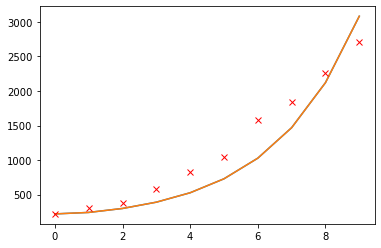

In [122]:
ENERGY = 'I'
cases_multiplier = 1
deaths_multiplier = 1
exposed_multiplier = 0
fit_range = (0, 10)
df = pd.read_csv('../data/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
df['D'] = deaths_multiplier*df['deceduti']
df['I'] = cases_multiplier*df['totale_positivi']
df['I1'] = df['isolamento_domiciliare'] # mild infected
df['I2'] = df['ricoverati_con_sintomi'] # severe infected
df['I3'] = df['terapia_intensiva'] # critical infected
df['R'] = df['dimessi_guariti'] # recovered
N = 60431283 # population
y_fit = df[ENERGY].values # variable to fit
I10 = df['I1'].iloc[fit_range[0]]
I20 = df['I2'].iloc[fit_range[0]]
I30 = df['I3'].iloc[fit_range[0]]
R0 = df['R'].iloc[fit_range[0]]
E0 = exposed_multiplier * df['I'].iloc[fit_range[0]]
D0 = df['D'].iloc[fit_range[0]]
S0 = N - E0 - I10 - I20 - I30 - R0 - D0 
time_range = 300
beta1, beta2, beta3, IncubPeriod, DurMildInf, FracSevere, FracCritical,  DurHosp, DurICU, CFR = calibrate_SEIIIRD(
    ENERGY = ENERGY,
    y = y_fit,
    fit_range = fit_range,
    S0 = S0,
    I10 = I10,
    I20 = I20,
    I30 = I30,
    R0 = R0,
    E0 = E0,
    D0 = D0,
    bounds= [
        (0, .9), #beta1
        (0, .1),#beta2
        (0, .1),#beta3
        (1, 30), #IncubPeriod
        (1, 30), #DurMildInf
        (0.01, 0.3), #FracSevere
        (0.01, 0.1),#FracCritical
        (1, 30), #DurHosp
        (1, 30), #DurICU
        (0, 0.051), #CFR
       ],
    use_differential_evolution = False,
    plot_range = 100,
    plot_output = ['I','D']
)

In [38]:
S, E, I1, I2, I3, R, D = SEIIIRDModel(range(time_range), S0, E0, I10, I20, I30,
                                          R0, D0, beta1, beta2, beta3,
                                          IncubPeriod, DurMildInf,
                                          FracSevere, FracCritical,
                                          DurHosp, DurICU, CFR)
I = I1 + I2 + I3
FracMild = 1. - FracSevere - FracCritical
alpha = 1 / IncubPeriod
gamma1 = (1 / DurMildInf) * FracMild
p1 = (1 / DurMildInf) - gamma1
p2 = (1 / DurHosp) * (FracCritical / (FracSevere + FracCritical))
gamma2 = (1 / DurHosp) - p2
mu = (1 / DurICU) * (CFR / FracCritical)
gamma3 = (1 / DurICU) - mu
r0 = 1 / (p1 + gamma1) * (beta1 + p1 / (p2 + gamma2) * (beta2 + beta3 * p2 / (mu * gamma3)))
print('max number of infections ', int(np.max(I)))
print('peak of infections ', np.argmax(I))
print('max number of exposed ', int(np.max(E)))
print('max number of recovered ', int(np.max(R)))
print('max number of deaths ', int(np.max(D)))
print('r0 ', r0)
cases = {'I': I, 'I1': I1, 'I2': I2, 'I3': I3, 'S': S, 'E': E, 'R': R, 'D': D}

max number of infections  20051350
peak of infections  37
max number of exposed  11994014
max number of recovered  55266712
max number of deaths  4936635
r0  -3.7825005957961957


In [47]:
fig.add_trace(go.Scatter(x=list(range(time_range)), y=I, mode='lines', name='Total Infections'))

In [50]:
y_fit

array([    7,    10,    12,    17,    21,    29,    34,    52,    79,
         107,   148,   197,   233,   366,   463,   631,   827,  1016,
        1266,  1441,  1809,  2158,  2503,  2978,  3405,  4032,  4825,
        5476,  6077,  6820,  7503,  8165,  9134, 10023, 10779, 11591,
       12428], dtype=int64)

In [52]:
cases['I']

array([2.06030000e+04, 2.10156357e+04, 2.43617361e+04, 3.00474845e+04,
       3.80185632e+04, 4.85613547e+04, 6.22213813e+04, 7.97860088e+04,
       1.02305893e+05, 1.31143739e+05, 1.68046307e+05, 2.15239452e+05,
       2.75548036e+05, 3.52543292e+05, 4.50719888e+05, 5.75703192e+05,
       7.34483300e+05, 9.35665308e+05, 1.18971337e+06, 1.50914755e+06,
       1.90862575e+06, 2.40480691e+06, 3.01585054e+06, 3.76036904e+06,
       4.65563624e+06, 5.71490191e+06, 6.94381419e+06, 8.33624505e+06,
       9.87023591e+06, 1.15052147e+07, 1.31818451e+07, 1.48255753e+07,
       1.63540303e+07, 1.76870768e+07, 1.87572734e+07, 1.95181268e+07,
       1.99483079e+07, 2.00513501e+07, 1.98516760e+07, 1.93885343e+07,
       1.87094775e+07, 1.78645839e+07, 1.69020542e+07, 1.58653228e+07,
       1.47915121e+07, 1.37109225e+07, 1.26472271e+07, 1.16180911e+07,
       1.06359979e+07, 9.70913444e+06, 8.84224396e+06, 8.03739431e+06,
       7.29463943e+06, 6.61256952e+06, 5.98875599e+06, 5.42010244e+06,
      